Loaded C:/Users/asus/Downloads/DATA_S2/S2_40480.npy with shape (38, 10, 128, 128), dtype int16
Auto NDVI threshold set to: 0.3526


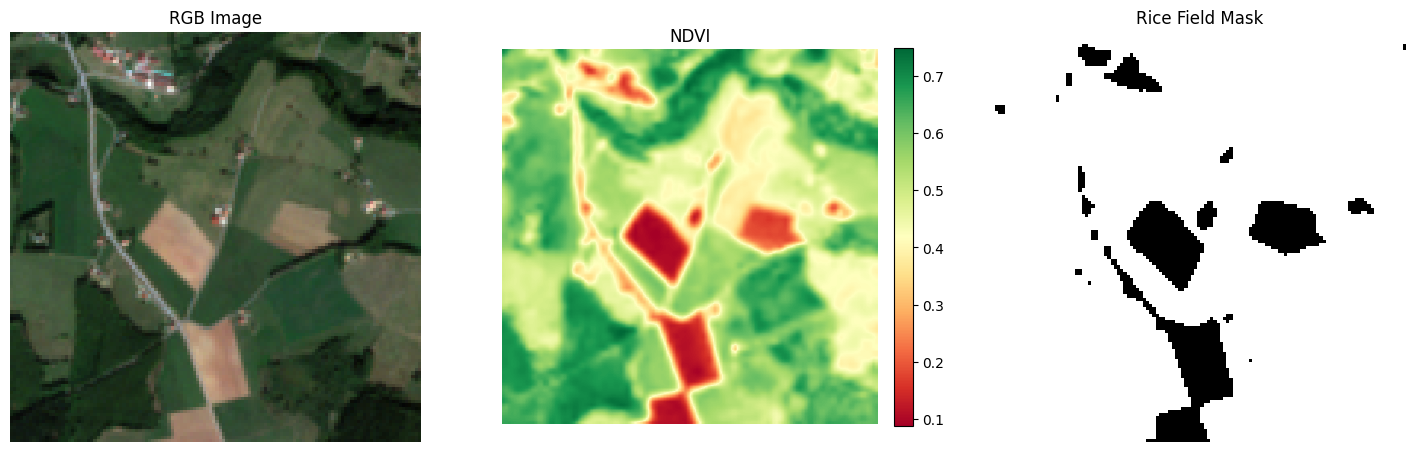

(array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]], shape=(128, 128)),
 array([[0.71013235, 0.68601414, 0.6481088 , ..., 0.44074276, 0.44620338,
         0.39362287],
        [0.68777429, 0.65808152, 0.61248741, ..., 0.45705706, 0.44535442,
         0.38036117],
        [0.65147561, 0.62401575, 0.5860575 , ..., 0.46778711, 0.44178082,
         0.36859972],
        ...,
        [0.64745763, 0.64784689, 0.64728313, ..., 0.61328125, 0.61710935,
         0.625     ],
        [0.65500945, 0.65559772, 0.65283739, ..., 0.61923327, 0.61992494,
         0.62508859],
        [0.65851364, 0.66003788, 0.6614937 , ..., 0.6187175 , 0.62265487,
         0.62642857]], shape=(128, 128)),
 array([[[0.0791

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def load_data(file_path):
    data = np.load(file_path)
    print(f"Loaded {file_path} with shape {data.shape}, dtype {data.dtype}")
    return data

def calculate_ndvi(image, red_band=3, nir_band=7):
    RED = image[red_band].astype(float)
    NIR = image[nir_band].astype(float)
    ndvi = (NIR - RED) / (NIR + RED + 1e-6)
    return ndvi

def segment_rice_field(ndvi, threshold=None):
    if threshold is None:
        threshold = ndvi.min() + 0.4 * (ndvi.max() - ndvi.min())
        print(f"Auto NDVI threshold set to: {threshold:.4f}")
    mask = ndvi > threshold
    return mask, threshold

def get_rgb(image, bands=[2,1,0]):
    rgb = image[bands].astype(float)
    mx = rgb.max(axis=(1,2), keepdims=True)
    mn = rgb.min(axis=(1,2), keepdims=True)
    rgb_norm = (rgb - mn) / (mx - mn + 1e-6)
    rgb_img = np.transpose(rgb_norm, (1,2,0))
    return rgb_img

def plot_results(rgb, ndvi, rice_mask):
    fig, axs = plt.subplots(1,3, figsize=(18,6))

    axs[0].imshow(rgb)
    axs[0].set_title("RGB Image")
    axs[0].axis('off')

    im1 = axs[1].imshow(ndvi, cmap='RdYlGn')
    axs[1].set_title("NDVI")
    axs[1].axis('off')
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    axs[2].imshow(rice_mask, cmap='gray')
    axs[2].set_title("Rice Field Mask")
    axs[2].axis('off') 

    plt.show()

def process_single_file(file_path):
    data = load_data(file_path)
    image = data[0] 
    ndvi = calculate_ndvi(image)
    rice_mask, threshold = segment_rice_field(ndvi)
    rgb_img = get_rgb(image)
    plot_results(rgb_img, ndvi, rice_mask)

    return rice_mask, ndvi, rgb_img, threshold

file_path = r"C:/Users/asus/Downloads/DATA_S2/S2_40480.npy"
process_single_file(file_path)

Loaded C:/Users/asus/Downloads/DATA_S2/S2_40480.npy with shape (38, 10, 128, 128), dtype int16
Auto NDVI threshold set to: 0.3526


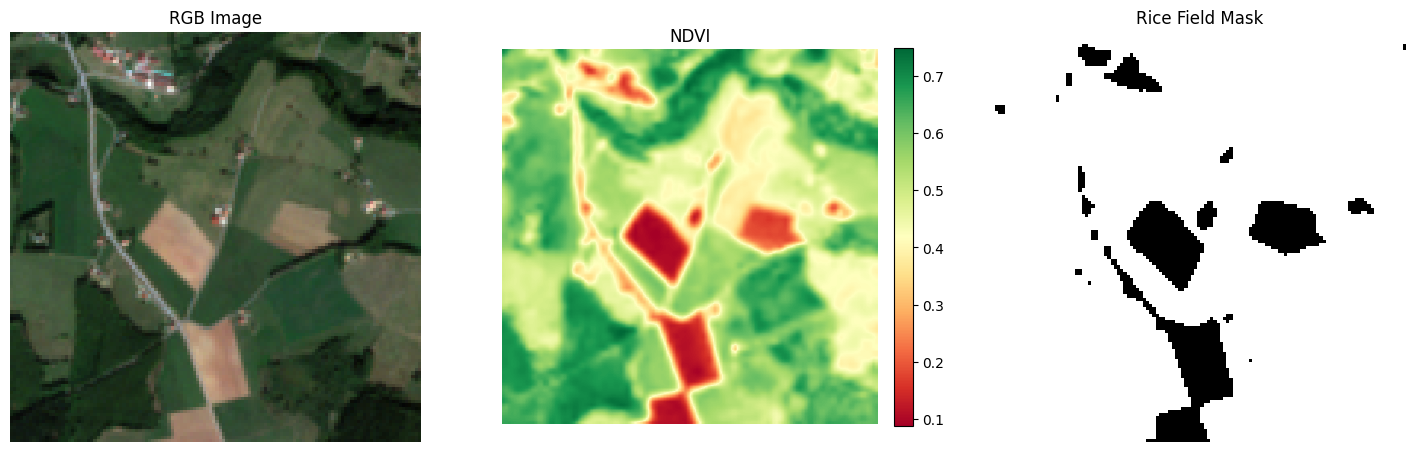

In [9]:
rice_mask, ndvi, rgb_img, threshold = process_single_file(file_path)

Nilai min/max channel hijau: 0.21960784 0.83137256


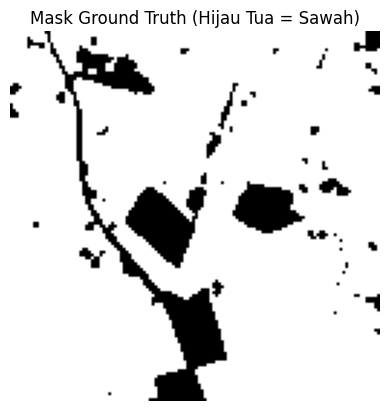

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

img = mpimg.imread("C:/Users/asus/Downloads/ground_truth.png")

green = img[:, :, 1]

print("Nilai min/max channel hijau:", green.min(), green.max())

threshold = 0.4
mask_gt = (green < threshold).astype(np.uint8)

plt.imshow(mask_gt, cmap='gray')
plt.title("Mask Ground Truth (Hijau Tua = Sawah)")
plt.axis('off')
plt.show()

In [11]:
import numpy as np

y_true = mask_gt.flatten()
y_pred = rice_mask.flatten()

TP = np.sum((y_pred == 1) & (y_true == 1)) 
TN = np.sum((y_pred == 0) & (y_true == 0)) 
FP = np.sum((y_pred == 1) & (y_true == 0))  
FN = np.sum((y_pred == 0) & (y_true == 1)) 

precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
recall_0    = TN / (TN + FP) if (TN + FP) > 0 else 0
f1_0        = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
support_0   = TN + FP

precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
recall_1    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_1        = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
support_1   = TP + FN

accuracy = (TP + TN) / (TP + TN + FP + FN)

macro_precision = (precision_0 + precision_1) / 2
macro_recall    = (recall_0 + recall_1) / 2
macro_f1        = (f1_0 + f1_1) / 2

total = support_0 + support_1
weighted_precision = (precision_0 * support_0 + precision_1 * support_1) / total
weighted_recall    = (recall_0 * support_0 + recall_1 * support_1) / total
weighted_f1        = (f1_0 * support_0 + f1_1 * support_1) / total

print(f"\nAkurasi NDVI vs Ground Truth: {accuracy*100:.2f} %\n")
print("Confusion Matrix:")
print(f"[[ {TN} {FP} ]\n [ {FN} {TP} ]]\n")

print("Classification Report:")
print(f"{'':<12}{'precision':<10}{'recall':<10}{'f1-score':<10}{'support'}")
print(f"{'Non-Sawah':<12}{precision_0:<10.2f}{recall_0:<10.2f}{f1_0:<10.2f}{support_0}")
print(f"{'Sawah':<12}{precision_1:<10.2f}{recall_1:<10.2f}{f1_1:<10.2f}{support_1}")
print(f"\n{'accuracy':<12}{'':<10}{'':<10}{accuracy:<10.2f}{total}")
print(f"{'macro avg':<12}{macro_precision:<10.2f}{macro_recall:<10.2f}{macro_f1:<10.2f}{total}")
print(f"{'weighted avg':<12}{weighted_precision:<10.2f}{weighted_recall:<10.2f}{weighted_f1:<10.2f}{total}")


Akurasi NDVI vs Ground Truth: 94.02 %

Confusion Matrix:
[[ 1344 762 ]
 [ 218 14060 ]]

Classification Report:
            precision recall    f1-score  support
Non-Sawah   0.86      0.64      0.73      2106
Sawah       0.95      0.98      0.97      14278

accuracy                        0.94      16384
macro avg   0.90      0.81      0.85      16384
weighted avg0.94      0.94      0.94      16384
